In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import norm
from IPython.display import display

In [30]:
base_path = r"D:\Jupyter notebook\files\Optimization\MKF-master\data"
robot_num = 1  # Номер робота (1-5)

landmark_file = f"{base_path}/Landmark_Groundtruth.csv"
landmark = pd.read_csv(landmark_file, sep="\s+", header=None,
                      names=['id', 'x', 'y', 'std_x', 'std_y'])
print(f"Загружено {len(landmark)} маркеров")


groundtruth_file = f"{base_path}/Robot{robot_num}_Groundtruth.csv"
groundtruth = pd.read_csv(groundtruth_file, sep="\s+", header=None,
                         names=['time', 'x', 'y', 'yaw'])

odometry_file = f"{base_path}/Robot{robot_num}_Odometry.csv"
odometry = pd.read_csv(odometry_file, sep="\s+", header=None,
                      names=['time', 'v', 'w'])

measurement_file = f"{base_path}/Robot{robot_num}_Measurement.csv"
measurements = pd.read_csv(measurement_file, sep="\s+", header=None,
                          names=['time', 'id', 'range', 'bearing'])


Загружено 15 маркеров


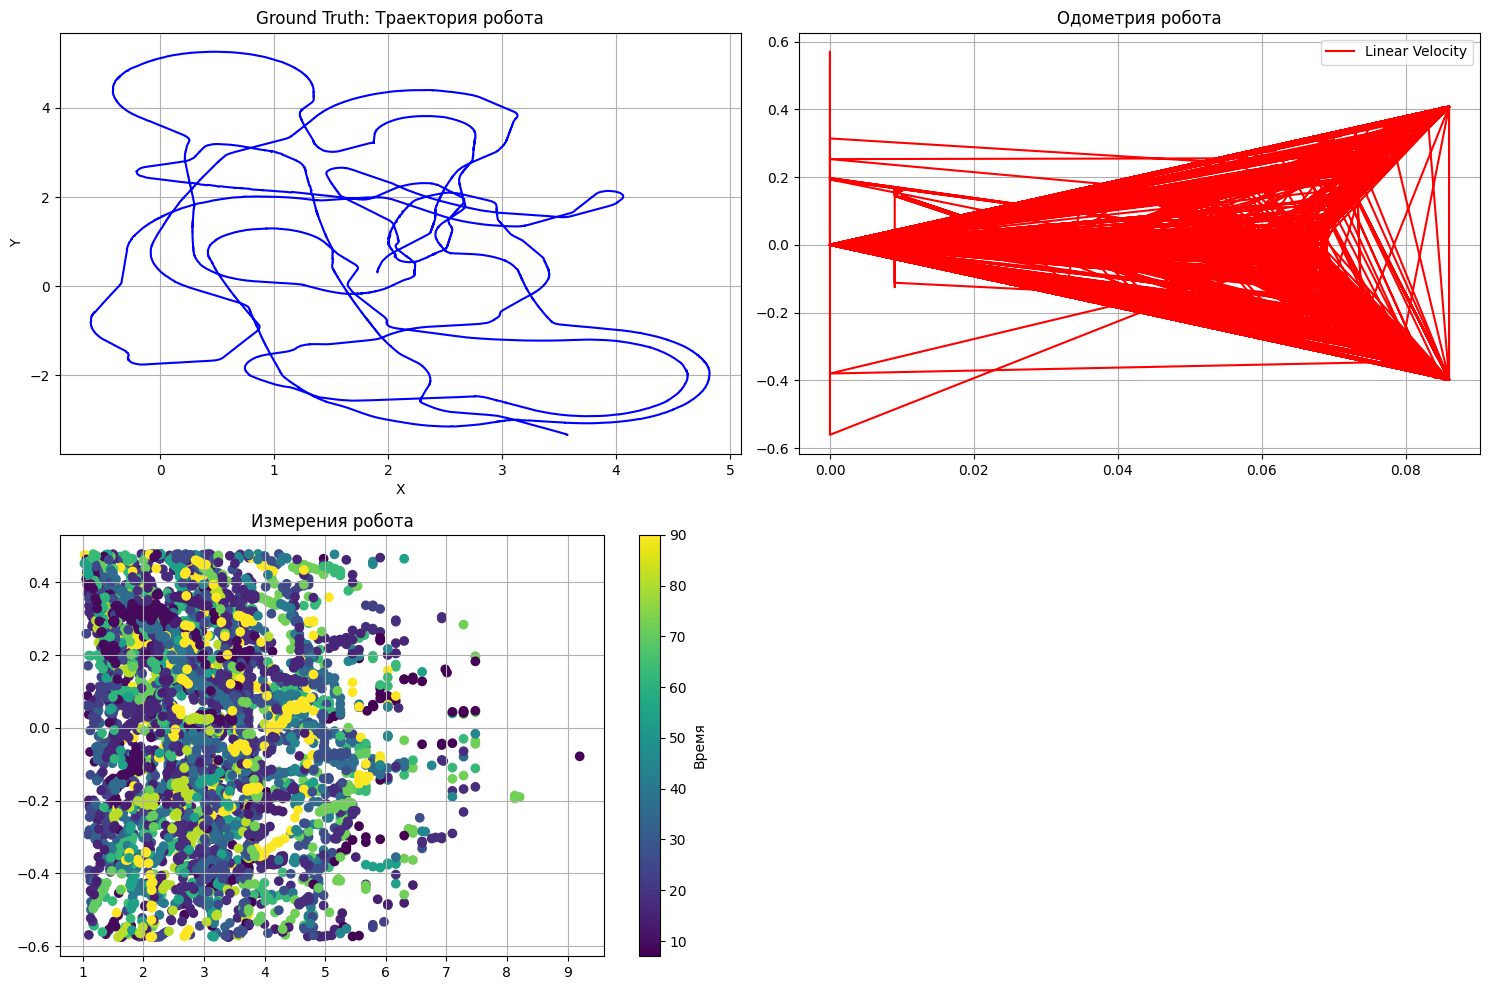

In [31]:
# base_path = r"D:\Jupyter notebook\files\Optimization\MKF-master\data"
# groundtruth = pd.read_csv(f"{base_path}/Robot1_Groundtruth.csv", sep="\s+", header=None)
# odometry = pd.read_csv(f"{base_path}/Robot1_Odometry.csv", sep="\s+", header=None)
# measurements = pd.read_csv(f"{base_path}/Robot1_Measurement.csv", sep="\s+", header=None)
# landmark = pd.read_csv(f"{base_path}/Landmark_Groundtruth.csv", sep="\s+", header=None)


plt.figure(figsize=(15, 10))

# 1. Траектория (Ground Truth)
plt.subplot(2, 2, 1)
plt.plot(groundtruth[1], groundtruth[2], 'b-', label="Траектория")
plt.title("Ground Truth: Траектория робота")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid()

# 2. Одометрия (проверяем количество столбцов)
plt.subplot(2, 2, 2)
if odometry.shape[1] >= 3: 
    plt.plot(odometry[1], odometry[2], 'r-', label="Linear Velocity")
    if odometry.shape[1] >= 4:
        plt.plot(odometry[1], odometry[3], 'g-', label="Angular Velocity")
plt.title("Одометрия робота")
plt.legend()
plt.grid()

# 3. Измерения (проверяем структуру)
plt.subplot(2, 2, 3)
if measurements.shape[1] >= 4:  
    plt.scatter(measurements[2], measurements[3], c=measurements[1], cmap='viridis')
    plt.colorbar(label="Время")
plt.title("Измерения робота")
plt.grid()

plt.tight_layout()
plt.show()

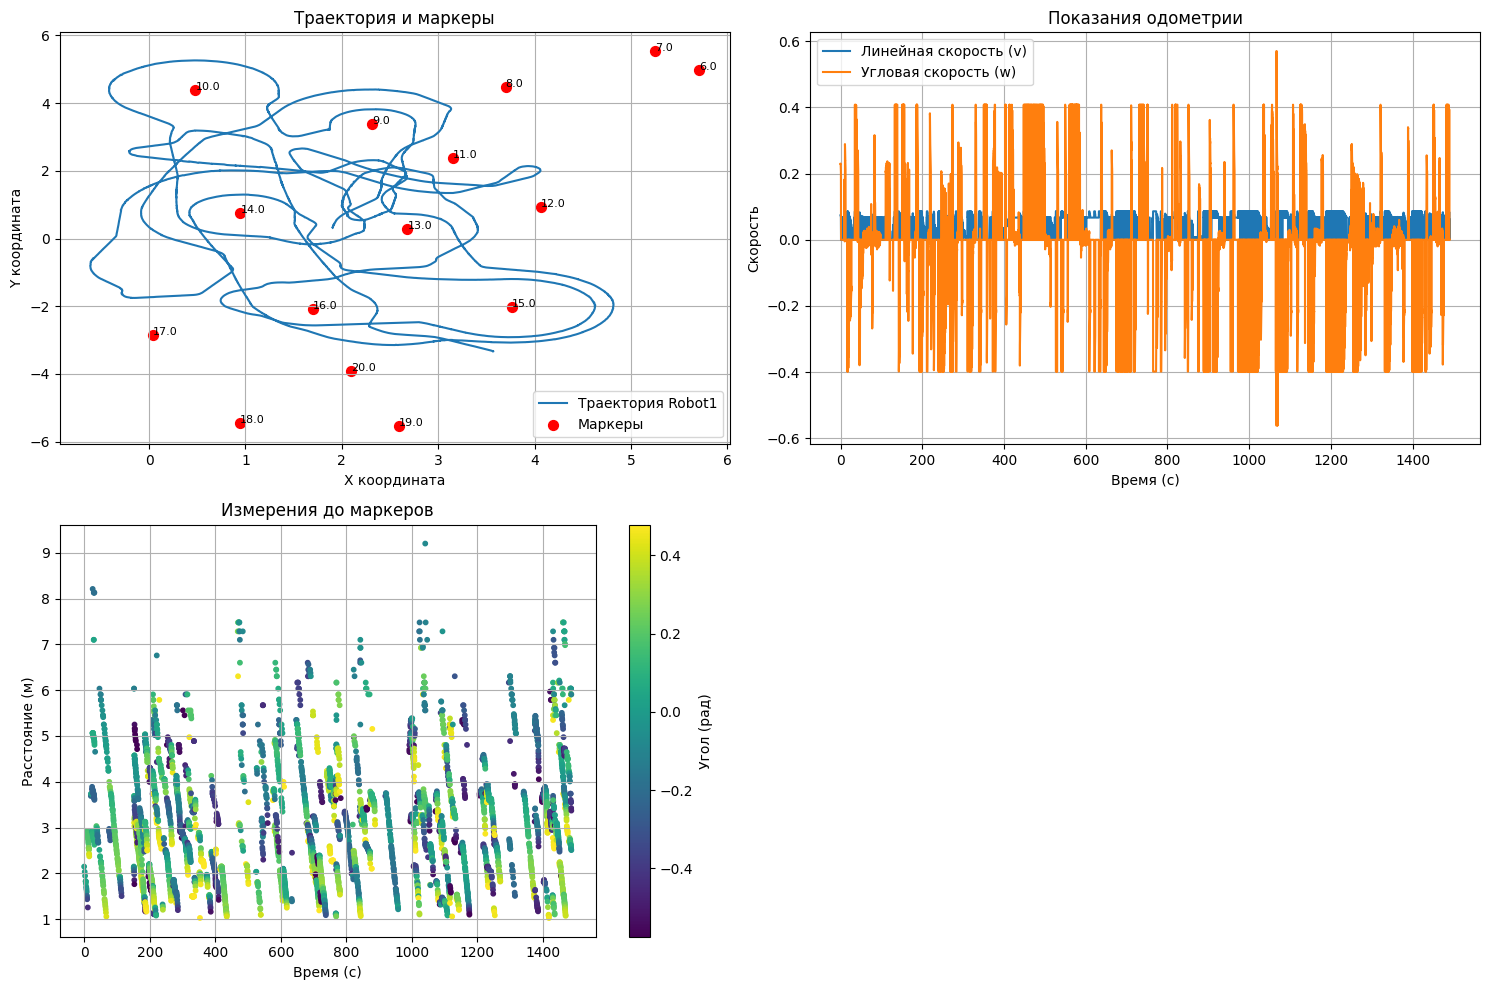

In [33]:
landmark.columns = ['id', 'x', 'y', 'std_x', 'std_y']
landmark_dict = {row.id: {'x': row.x, 'y': row.y, 'std_x': row.std_x, 'std_y': row.std_y} 
                for row in landmark.itertuples()}

groundtruth.columns = ['time', 'x', 'y', 'yaw']
groundtruth['time'] -= groundtruth['time'].iloc[0]  # Нормализация времени


odometry.columns = ['time', 'v', 'w']
odometry['time'] -= odometry['time'].iloc[0]


measurements.columns = ['time', 'id', 'range', 'bearing']
measurements['time'] -= measurements['time'].iloc[0]


barcode_map = {
    23: 5, 72: 6, 27: 7, 54: 8, 70: 9, 36: 10,
    18: 11, 25: 12, 9: 13, 81: 14, 16: 15, 90: 16,
    61: 17, 45: 18, 7: 19, 63: 20
}
measurements['subject'] = measurements['id'].map(barcode_map)

# 3. Визуализация данных=

plt.figure(figsize=(15, 10))

# 3.1 Траектория и маркеры
plt.subplot(2, 2, 1)
plt.plot(groundtruth['x'], groundtruth['y'], label='Траектория Robot1')
plt.scatter(landmark['x'], landmark['y'], c='red', s=50, label='Маркеры')
for _, row in landmark.iterrows():
    plt.text(row.x, row.y, f"{row.id}", fontsize=8)
plt.xlabel('X координата')
plt.ylabel('Y координата')
plt.title('Траектория и маркеры')
plt.legend()
plt.grid(True)


plt.subplot(2, 2, 2)
plt.plot(odometry['time'], odometry['v'], label='Линейная скорость (v)')
plt.plot(odometry['time'], odometry['w'], label='Угловая скорость (w)')
plt.xlabel('Время (с)')
plt.ylabel('Скорость')
plt.title('Показания одометрии')
plt.legend()
plt.grid(True)


plt.subplot(2, 2, 3)
valid_measurements = measurements[measurements['subject'].notna()]
plt.scatter(valid_measurements['time'], valid_measurements['range'], 
           c=valid_measurements['bearing'], cmap='viridis', s=10)
plt.colorbar(label='Угол (рад)')
plt.xlabel('Время (с)')
plt.ylabel('Расстояние (м)')
plt.title('Измерения до маркеров')
plt.grid(True)

plt.tight_layout()
plt.show()

,Метрика,Ошибка расстояния,Ошибка угла
0,Среднее,-0.670451,0.237730
1,Дисперсия,1.258160,1.300078
2,Среднеквадратичное,1.306676,1.164612


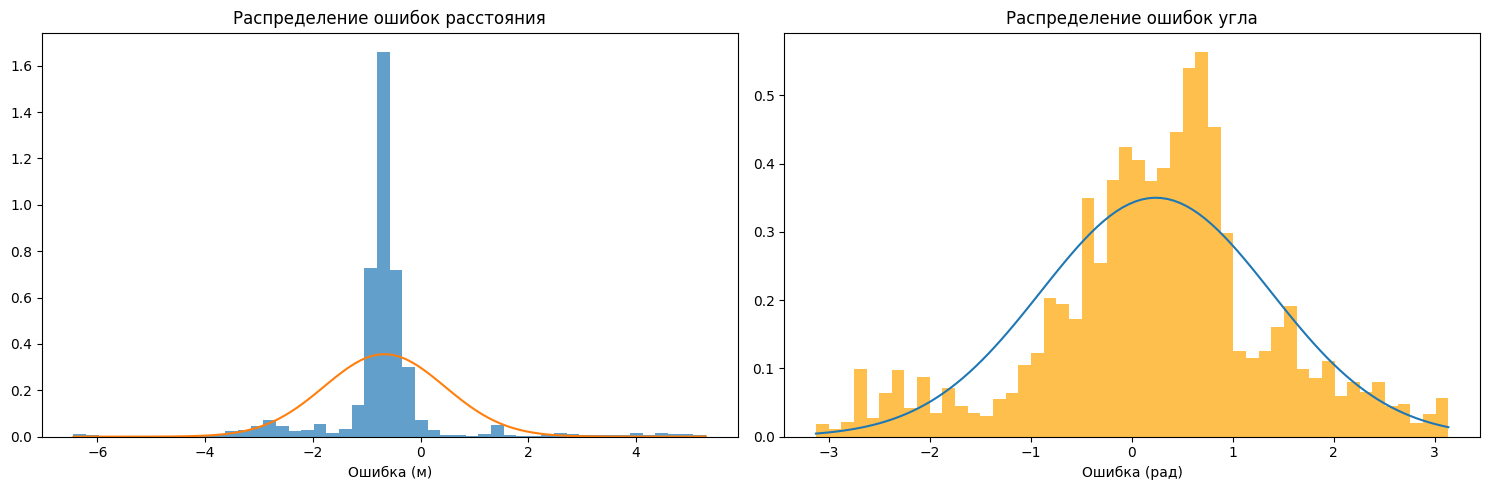

In [34]:
#  Анализ ошибок 

def normalize_angle(angle):
    """Нормализация угла в диапазон [-π, π]"""
    return (angle + np.pi) % (2 * np.pi) - np.pi

errors = []
for _, meas in valid_measurements.iterrows():
    # Находим ближайшее по времени эталонное положение
    time_diff = np.abs(groundtruth['time'] - meas['time'])
    gt_idx = time_diff.idxmin()
    gt = groundtruth.iloc[gt_idx]
    
    # Получаем координаты маркера
    landmark = landmark_dict.get(meas['subject'])
    if landmark is None:
        continue
    
    # Расчет истинных значений
    dx = landmark['x'] - gt['x']
    dy = landmark['y'] - gt['y']
    true_range = np.hypot(dx, dy)
    true_bearing = np.arctan2(dy, dx) - gt['yaw']
    true_bearing = normalize_angle(true_bearing)
    
    # Расчет ошибок
    error_range = meas['range'] - true_range
    error_bearing = normalize_angle(meas['bearing'] - true_bearing)
    
    errors.append({
        'time': meas['time'],
        'error_range': error_range,
        'error_bearing': error_bearing,
        'error_sq_range': error_range**2
    })

errors_df = pd.DataFrame(errors)

# Статистика ошибок
stats = pd.DataFrame({
    'Метрика': ['Среднее', 'Дисперсия', 'Среднеквадратичное'],
    'Ошибка расстояния': [
        errors_df['error_range'].mean(),
        errors_df['error_range'].var(),
        np.sqrt(errors_df['error_sq_range'].mean())
    ],
    'Ошибка угла': [
        errors_df['error_bearing'].mean(),
        errors_df['error_bearing'].var(),
        np.sqrt((errors_df['error_bearing']**2).mean())
    ]
})
display(stats)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.hist(errors_df['error_range'], bins=50, density=True, alpha=0.7)
x = np.linspace(errors_df['error_range'].min(), errors_df['error_range'].max(), 100)
plt.plot(x, norm.pdf(x, errors_df['error_range'].mean(), errors_df['error_range'].std()))
plt.title('Распределение ошибок расстояния')
plt.xlabel('Ошибка (м)')

plt.subplot(1, 2, 2)
plt.hist(errors_df['error_bearing'], bins=50, density=True, alpha=0.7, color='orange')
x = np.linspace(errors_df['error_bearing'].min(), errors_df['error_bearing'].max(), 100)
plt.plot(x, norm.pdf(x, errors_df['error_bearing'].mean(), errors_df['error_bearing'].std()))
plt.title('Распределение ошибок угла')
plt.xlabel('Ошибка (рад)')

plt.tight_layout()
plt.show()

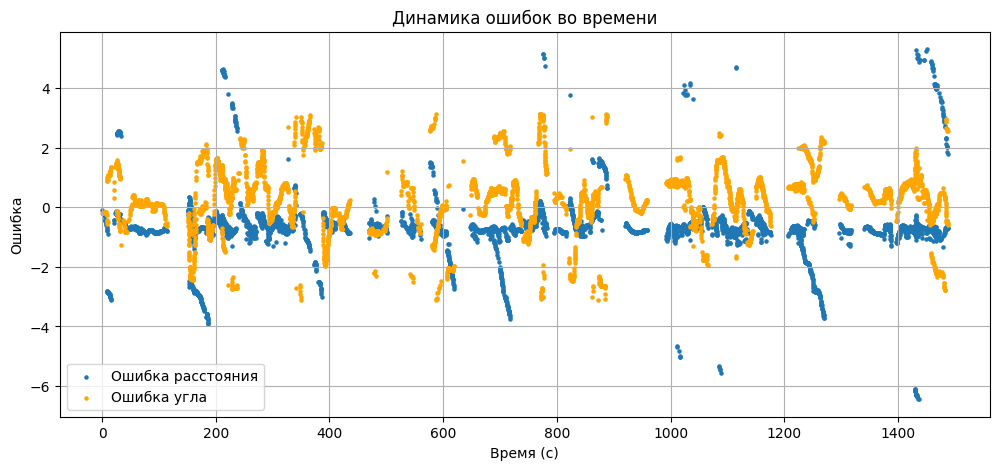

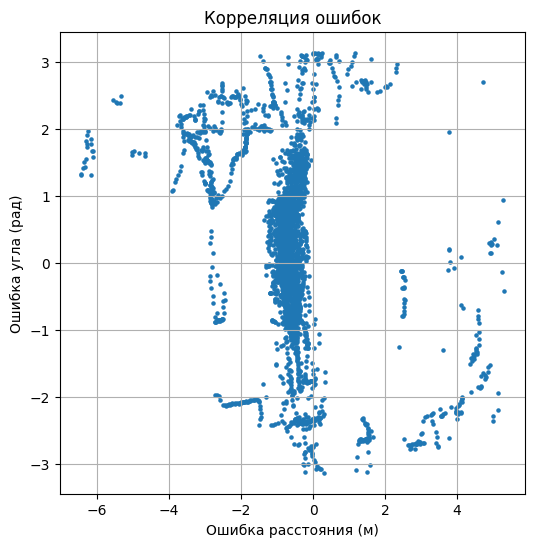

In [35]:
#  Зависимость ошибок от времени
plt.figure(figsize=(12, 5))
plt.scatter(errors_df['time'], errors_df['error_range'], s=5, label='Ошибка расстояния')
plt.scatter(errors_df['time'], errors_df['error_bearing'], s=5, label='Ошибка угла', color='orange')
plt.xlabel('Время (с)')
plt.ylabel('Ошибка')
plt.title('Динамика ошибок во времени')
plt.legend()
plt.grid(True)
plt.show()

# Корреляция ошибок
plt.figure(figsize=(6, 6))
plt.scatter(errors_df['error_range'], errors_df['error_bearing'], s=5)
plt.xlabel('Ошибка расстояния (м)')
plt.ylabel('Ошибка угла (рад)')
plt.title('Корреляция ошибок')
plt.grid(True)
plt.show()